# Capstone Project : COVID-19 Exploratory Data Analysis
---

The global datasets comes from the GitHub data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). This is also the source for the Kaggle competition dataset. In this part of the project, we go through with EDA on the data prepared.

---


#### Import Tools & Datasets

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
import seaborn as sns
sns.set()  # Set style & figures inline

import numpy as np 
import pandas as pd 
import random
import math
import datetime
# import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('fivethirtyeight')
%matplotlib inline


C:\Users\domin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load global cases for confirmed/deaths/recovered
confirmed_df = pd.read_csv('./datasets/confirmed_df.csv')
deaths_df = pd.read_csv('./datasets/deaths_df.csv')
recovered_df = pd.read_csv('./datasets/recovered_df.csv')
comb_ext = pd.read_csv('./datasets/comb_ext.csv')
# latest_data = pd.read_csv('./datasets/latest_data.csv')

# include Singapore specific dataframe
sg_df = pd.read_csv('./datasets/df_sg_covid.csv')
age_details_df = pd.read_csv('./datasets/age_details.csv')
nat_details_df = pd.read_csv('./datasets/nat_details.csv')
source_df = pd.read_csv('./datasets/source_details.csv')
rec_df = pd.read_csv('./datasets/recovery_details.csv')

# importing datetime formatted training and test dataset that was previously created
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [3]:
# kaggle dataset 
# world_population = pd.read_csv('./datasets/population_by_country_2020.csv')
# world_population.info()

---
### Global Dataset

In [4]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)

print('The number of confirmed cases worldwide on {}'.format(world_confirmed))
print('The number of recovered cases worldwide on {}'.format(world_recovered))
print('The number of death cases worldwide on {}'.format(world_deaths))
print('The number of active cases worldwide on {}'.format(world_active))

The number of confirmed cases worldwide on 4/24/20    2809977
dtype: int64
The number of recovered cases worldwide on 4/24/20    789069
dtype: int64
The number of death cases worldwide on 4/24/20    197004
dtype: int64
The number of active cases worldwide on 4/24/20    2217912
dtype: int64


C:\Users\domin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


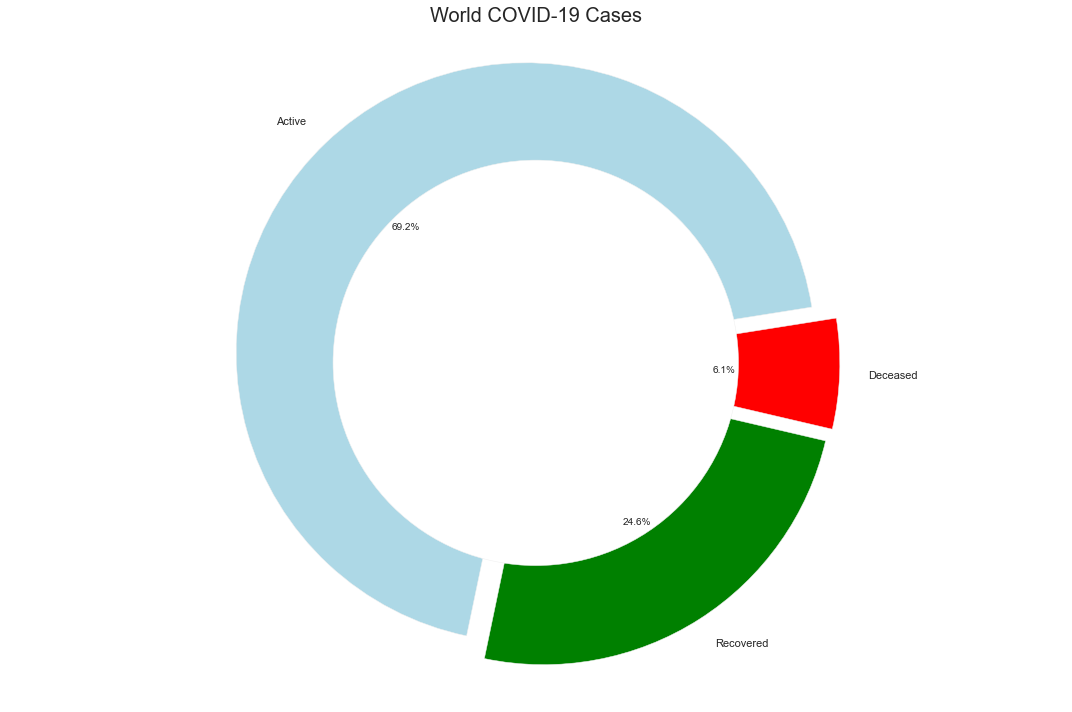

In [5]:
# pie chart for global covid data as of day -1
labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['lightblue','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

#### Top 10s for cases

In [6]:
# drop lat/long
comb_ext.drop(['Lat', 'Long'], axis=1, inplace=True)

In [7]:
# top 10 values for confirmed cases
comb_ext.sort_values(by='confirmed', ascending=False).head(10)

,Province/State,Country/Region,date,confirmed,deaths,recovered
23371,NaN,US,4/24/20,905358,51949,782
23122,NaN,US,4/23/20,869170,49954,504
22873,NaN,US,4/22/20,840351,46622,424
22624,NaN,US,4/21/20,811865,44444,367
22375,NaN,US,4/20/20,784326,42094,359
22126,NaN,US,4/19/20,758809,40661,347
21877,NaN,US,4/18/20,732197,38664,275
21628,NaN,US,4/17/20,699706,36787,246
21379,NaN,US,4/16/20,667592,32930,186
21130,NaN,US,4/15/20,636350,28338,143


In [8]:
# grouping by countries
comb_ext = comb_ext.groupby('Country/Region').sum().reset_index()

In [9]:
# top 10 countries for confirmed cases
top10_confirmed = comb_ext.sort_values(by='confirmed', ascending=False).head(10)
top10_confirmed

,Country/Region,confirmed,deaths,recovered
170,US,14592160,631749,4361
35,China,6183359,236263,4231671
83,Italy,4936614,597687,1175128
155,Spain,4736119,460486,4018
64,Germany,3574182,81763,48
60,France,3140242,367527,30696
174,United Kingdom,2243490,270200,194933
79,Iran,2231239,140666,4233
169,Turkey,1474373,32910,9550
16,Belgium,800790,92165,160132


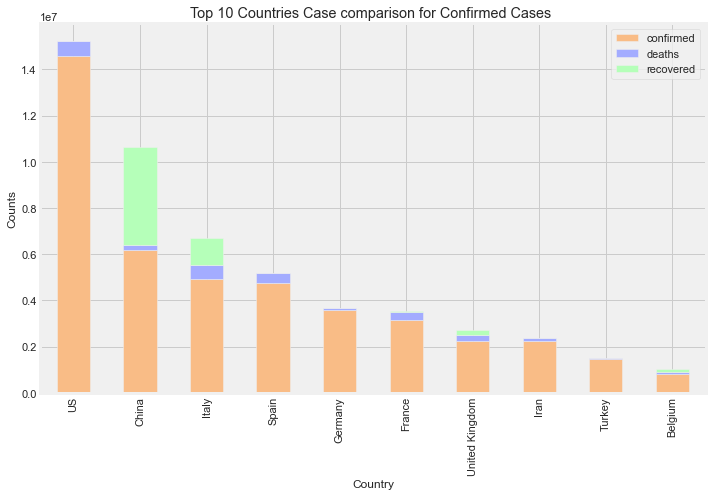

In [10]:
colours =  "#f9bc86", "#a3acff","#b5ffb9"
top10_confirmed.loc[:,['confirmed', 'deaths', 'recovered']].plot.bar(stacked=True, color=colours,  figsize=(10,7))


plt.xlabel('Country')
plt.xticks(np.arange(10), top10_confirmed['Country/Region'].tolist())
plt.ylabel('Counts')
plt.title('Top 10 Countries Case comparison for Confirmed Cases ')
plt.legend()

plt.tight_layout()

### Scope into ASEAN Countries

In [11]:
# ASEAN countries as countries of interest
coi = ["Brunei", "Burma", "Cambodia", "Indonesia", "Laos", "Malaysia", "Philippines", "Singapore", "Thailand", "Vietnam"]

In [12]:
# set indexed by date
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))

# creating empty list to be appended
global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

# function for grouping countries (excluding info on province/state)
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

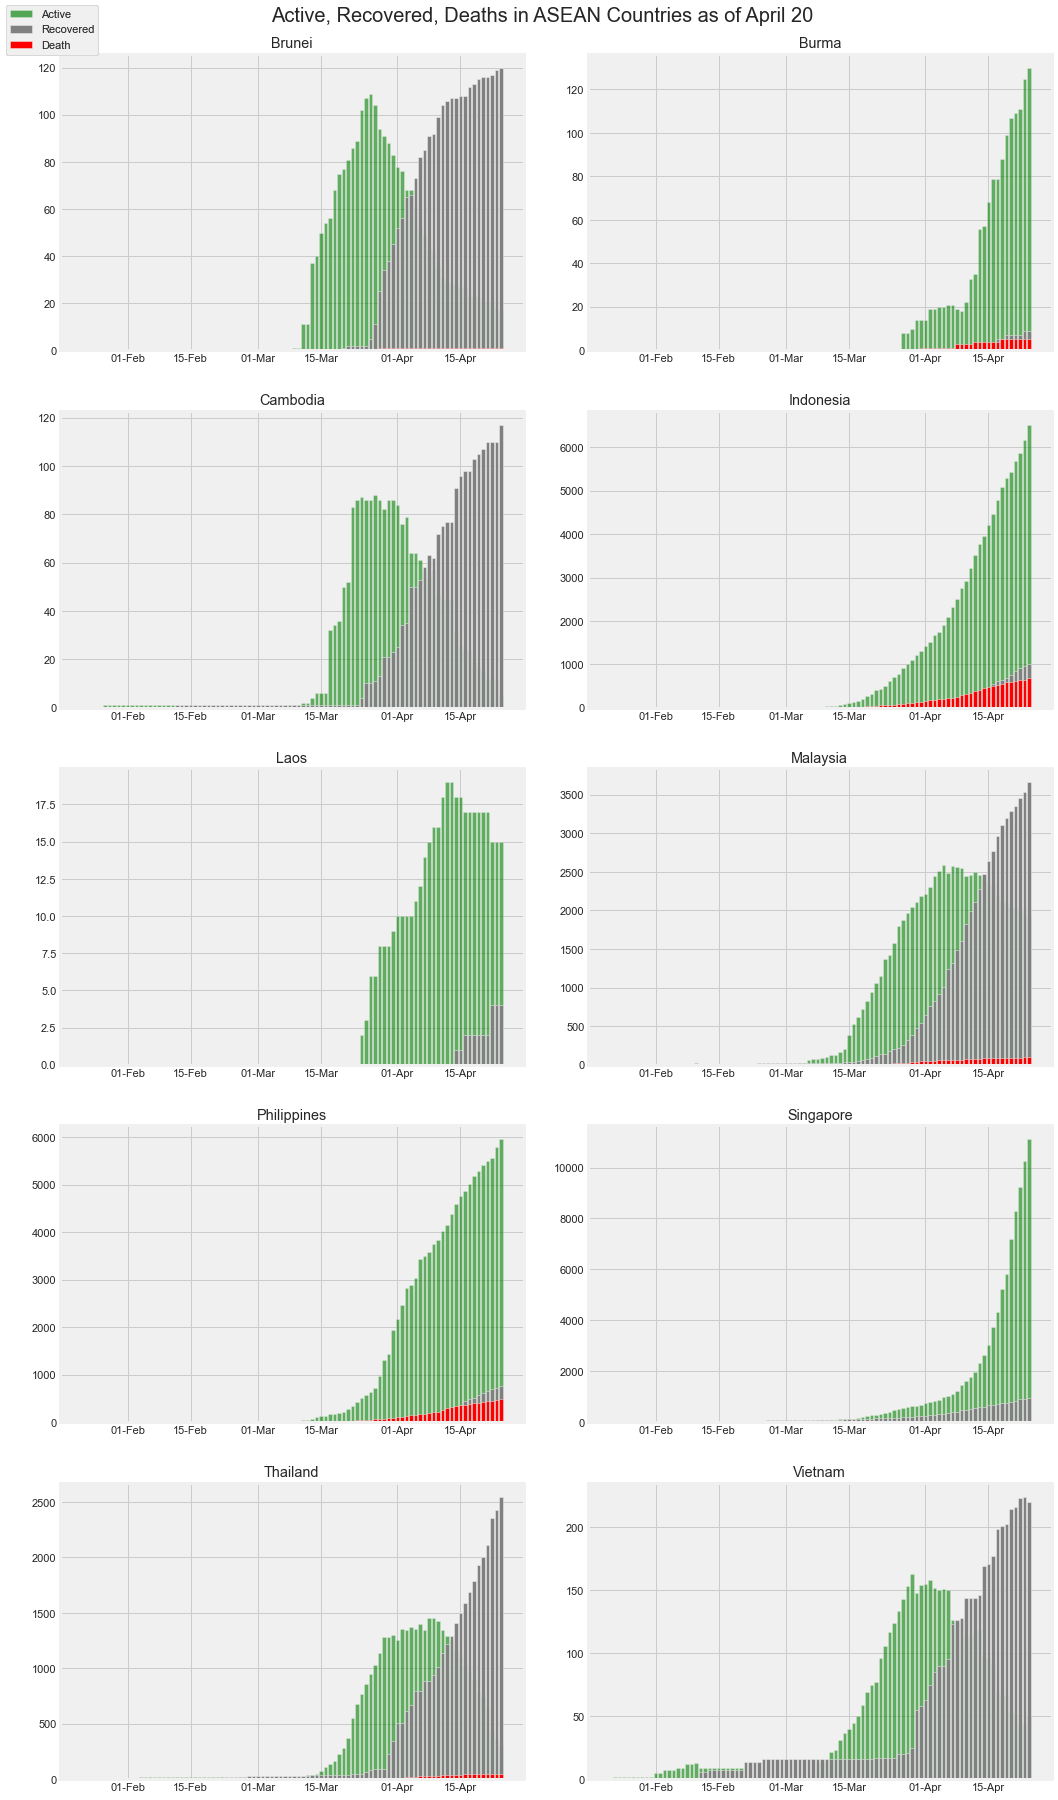

In [13]:
for country in coi:
    k =df1[df1['Country/Region'] == country].loc[:,'1/22/20':]  # findout why can't i input column number i.e. [4]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/22/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/22/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in coi:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,30))

plt.suptitle('Active, Recovered, Deaths in ASEAN Countries as of April 20',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,11):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.xaxis_date()
    ax.bar(dates, global_active[coi[k]], color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates, global_recovered[coi[k]], color='grey',label = 'Recovered');
    ax.bar(dates, global_deaths[coi[k]], color='red',label = 'Death');   
    plt.title(coi[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)


**Initial data shows the circumstance for countries with:** 
- Certain Recovery : Brunei, Cambodia, Malaysia Thailand, Vietnam (Flattened the Curve!) 
- Uncertain Recovery : Laos and Singapore (Hopeful to be Flattening!) 
- Burma (Myanmar), Indonesia, and Philippines showing very few recoveries or at a rate similar to those of deaths.

Comparison of cases amongst ASEAN Countries

In [14]:
# function for grouping countries
# returns data for countries indexed by date

def group_by_country(raw_data):
    
    # Group by
    data = raw_data.groupby(['Country/Region']).sum().drop(['Lat', 'Long'], axis=1)
    # Transpose
    data = data.transpose()
    # Set index as DateTimeIndex
    datetime_index = pd.DatetimeIndex(data.index)
    data.set_index(datetime_index, inplace=True)
    return data

# function to plot time series
def plot_time_series(df, plot_title, x_label, y_label, logy=True):

    ax = df.plot(figsize=(20,10), linewidth=2, marker='.', fontsize=20, logy=logy)
    ax.legend(ncol=3, loc='upper left')
    plt.xlabel(x_label, fontsize=20);
    plt.ylabel(y_label, fontsize=20);
    plt.title(plot_title, fontsize=20);

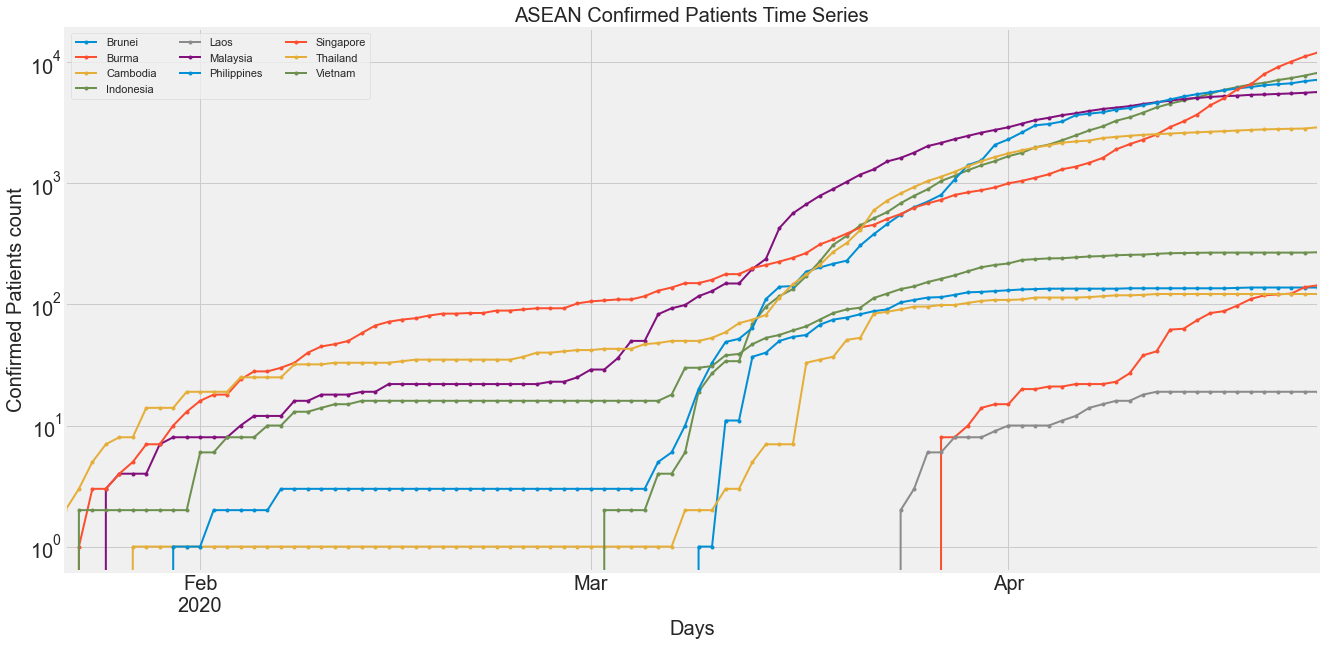

In [15]:
# ASEAN countries comparison of confirmed cases
plot_time_series(group_by_country(confirmed_df)[coi], 'ASEAN Confirmed Patients Time Series', 'Days', 'Confirmed Patients count')

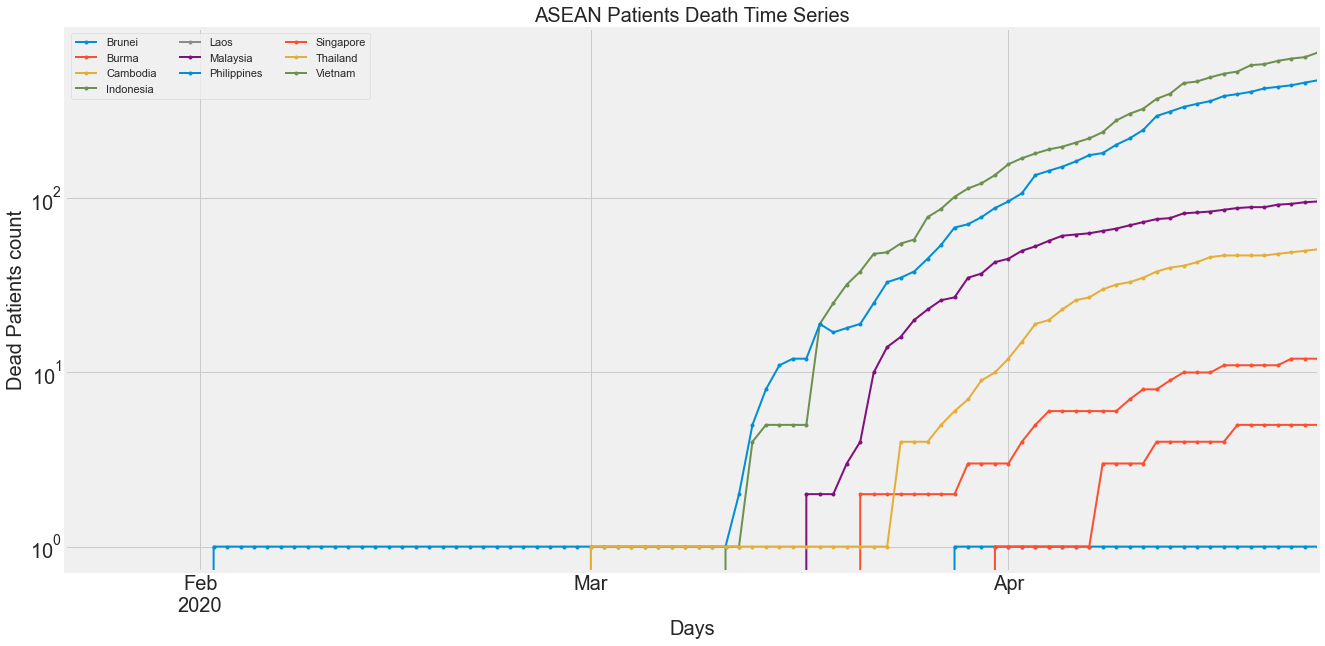

In [16]:
# ASEAN countries comparison of death cases
plot_time_series(group_by_country(deaths_df)[coi], 'ASEAN Patients Death Time Series', 'Days', 'Dead Patients count')

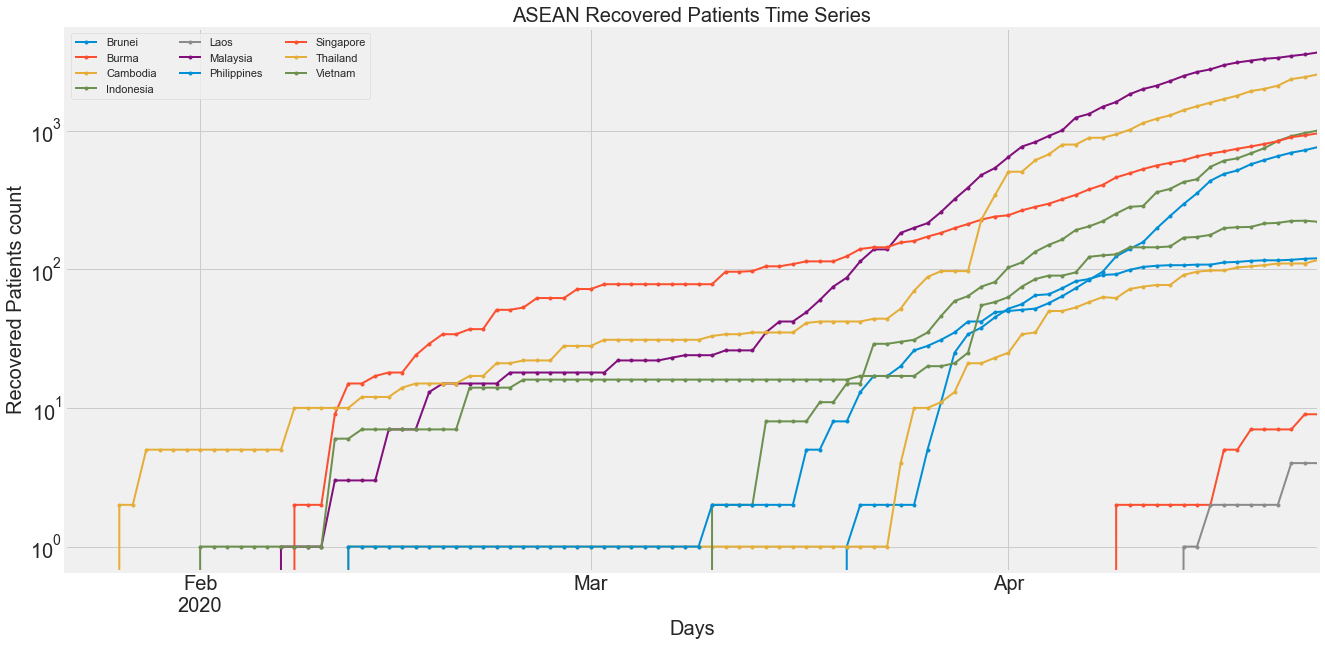

In [17]:
# ASEAN countries comparison of recovered cases
plot_time_series(group_by_country(recovered_df)[coi], 'ASEAN Recovered Patients Time Series', 'Days', 'Recovered Patients count')

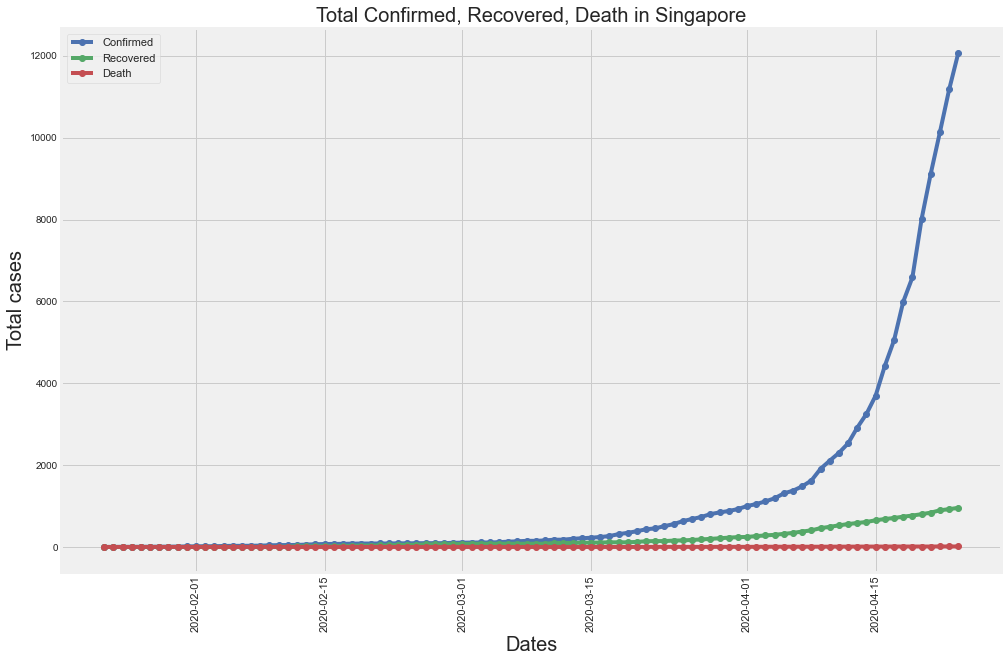

In [18]:
# plotting total cases for SG
SG_confirmed = df1[df1['Country/Region']=='Singapore'].loc[:,'1/22/20':].values.tolist()[0] 

SG_deaths = df2[df2['Country/Region']=='Singapore'].loc[:,'1/22/20':].values.tolist()[0] 

SG_recovered = df3[df3['Country/Region']=='Singapore'].loc[:,'1/22/20':].values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Recovered, Death in Singapore" , fontsize = 20)
# plt.axvline(x=4/7/20) include for representation fo start of lockdown

# plt.plot_date(y=0, x="2020-04-07", label = "Lockdown", linestyle ='-',color = '0')
ax1 = plt.plot_date(y= SG_confirmed,x= dates,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= SG_recovered,x= dates,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= SG_deaths,x= dates,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

### Bringing in the Singapore Contextual Data

In [19]:
# sg age group df extracted from sg only data
age_details_df

,group,total
0,30-39,2563
1,20-29,1989
2,40-49,1139
3,50-59,455
4,60-69,211
5,70-79,71
6,1-9,63
7,10-19,59
8,>80,38


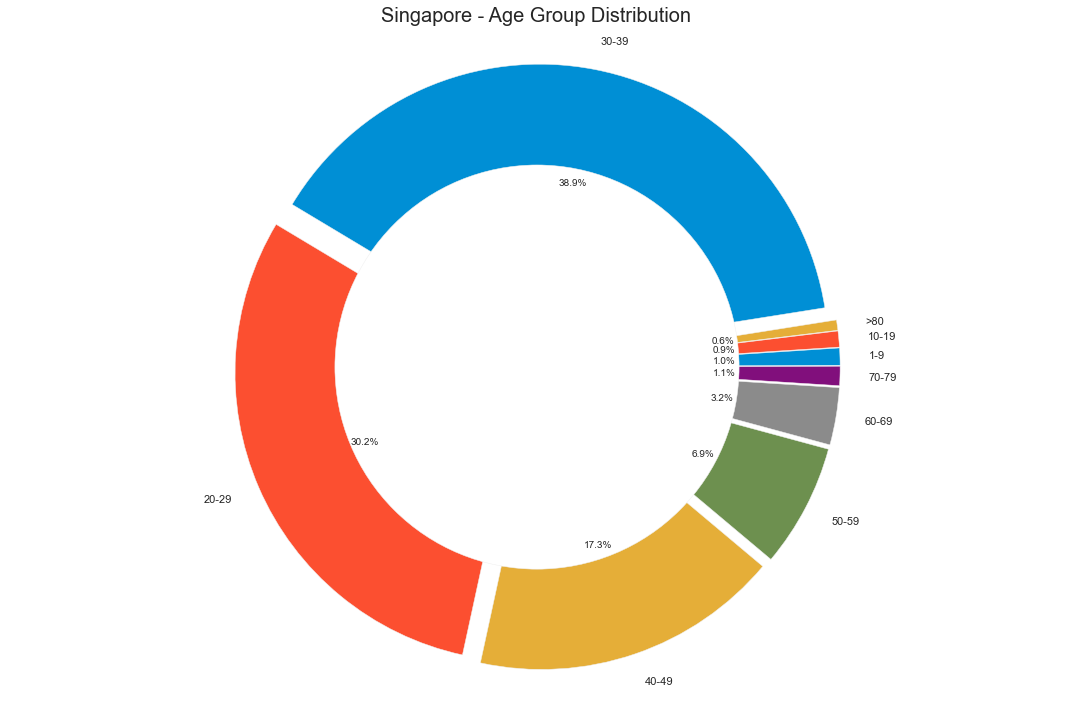

In [20]:
# plot pie chart showing SG age group distribution for covid cases
labels = list(age_details_df.group)
sizes = list(age_details_df.total)

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Singapore - Age Group Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

We could see that the age group 30-39 is the most affected, followed by 20-29 and 40-49. Possible correlation between age and working class. \
Though science says elderly people are more at risk of being affected, only 4.9% of people >60 are affected.

In [21]:
# SG only data 
sg_df.head()

,case,patient,age,gender,nationality,status,infection_source,country_of_origin,symptomatic_toconfirmation,days_torecover,symptomatic_at,confirmed_at,recovered_at,displayed_symptoms
0,6560.0,37 Year Old Male Bangladeshi,\n 37\n ...,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,-,-,-,"19th, Apr 2020",-,True
1,6558.0,37 Year Old Male Bangladeshi,\n 37\n ...,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,-,-,-,"19th, Apr 2020",-,True
2,6531.0,31 Year Old Male Bangladeshi,\n 31\n ...,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,-,-,-,"19th, Apr 2020",-,True
3,6529.0,43 Year Old Male Indian,\n 43\n ...,Male,Indian,In hospital,Local transmission,Unclear origin,-,-,-,"19th, Apr 2020",-,True
4,6509.0,31 Year Old Male Myanmarian,\n 31\n ...,Male,Myanmarian,In hospital,Local transmission,Unclear origin,-,-,-,"18th, Apr 2020",-,True


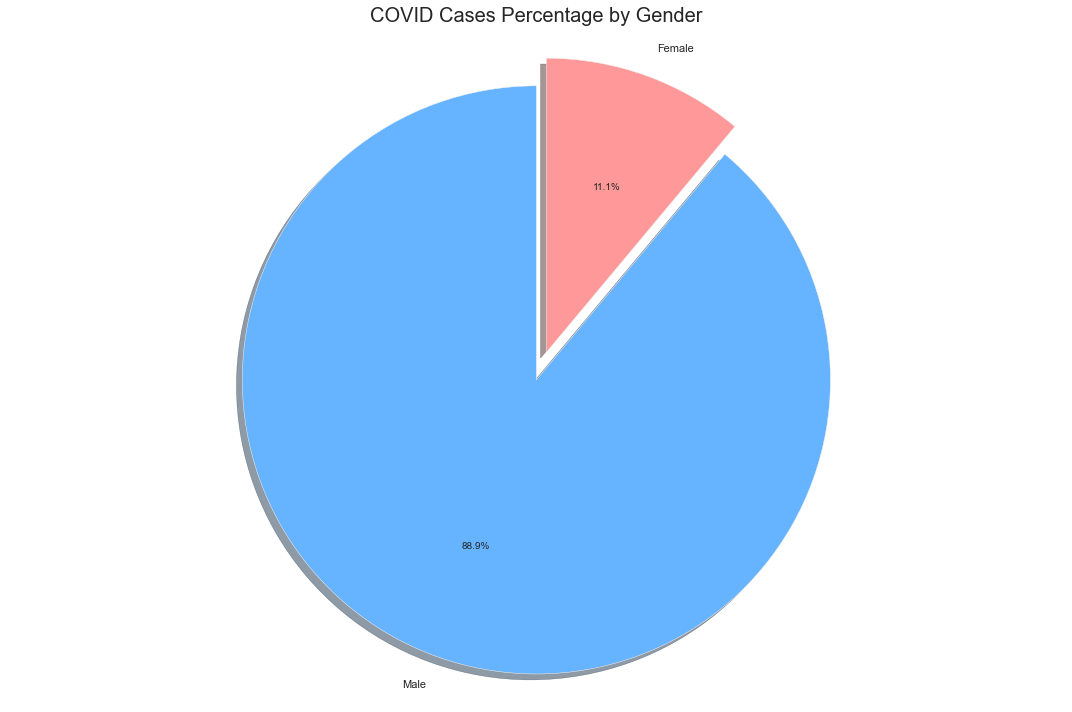

In [22]:
# plot pie chart showing SG gender distribution for covid cases
labels = ['Male', 'Female']
sizes = []

# no null values for genger
sizes.append(list(sg_df['gender'].value_counts())[0])
sizes.append(list(sg_df['gender'].value_counts())[1])

explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.title('COVID Cases Percentage by Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

We observe that a majority of the infected are men, with women only being 11.1%.

In [23]:
# include moving average for SG/ASEAN for confirmed cases

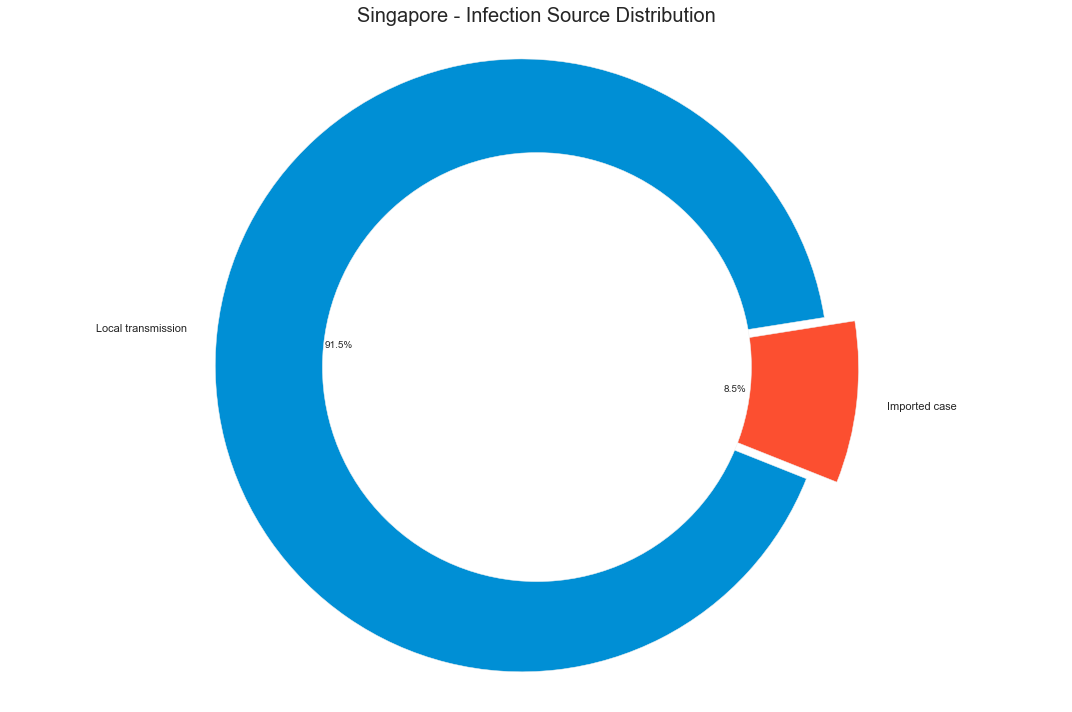

In [24]:
# plot pie chart showing SG age group distribution for covid cases
labels = list(source_df.source)
sizes = list(source_df.total)

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Singapore - Infection Source Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

We can observe that majority of the cases are locally transmitted and not imported.

In [25]:
# counts for different nationalities in singapore's confirmed cases
sg_df['nationality'].value_counts()

Bangladeshi                 2922
Indian                      1608
Singaporean                 1286
Chinese                      233
Myanmarian                   136
Malaysian                     95
Unidentified nationality      62
Filipino                      45
Thai                          39
Indonesian                    33
British                       30
Australian                    15
French                        14
American                      12
German                         7
Dutch                          6
Sri lankan                     5
Brazilian                      4
New zealander                  4
Japanese                       4
Swiss                          3
Irish                          3
Spanish                        3
Vietnamese                     2
Italian                        2
Swedish                        2
Omani                          1
Emirian                        1
Russian                        1
Venezuelan                     1
Slovak    

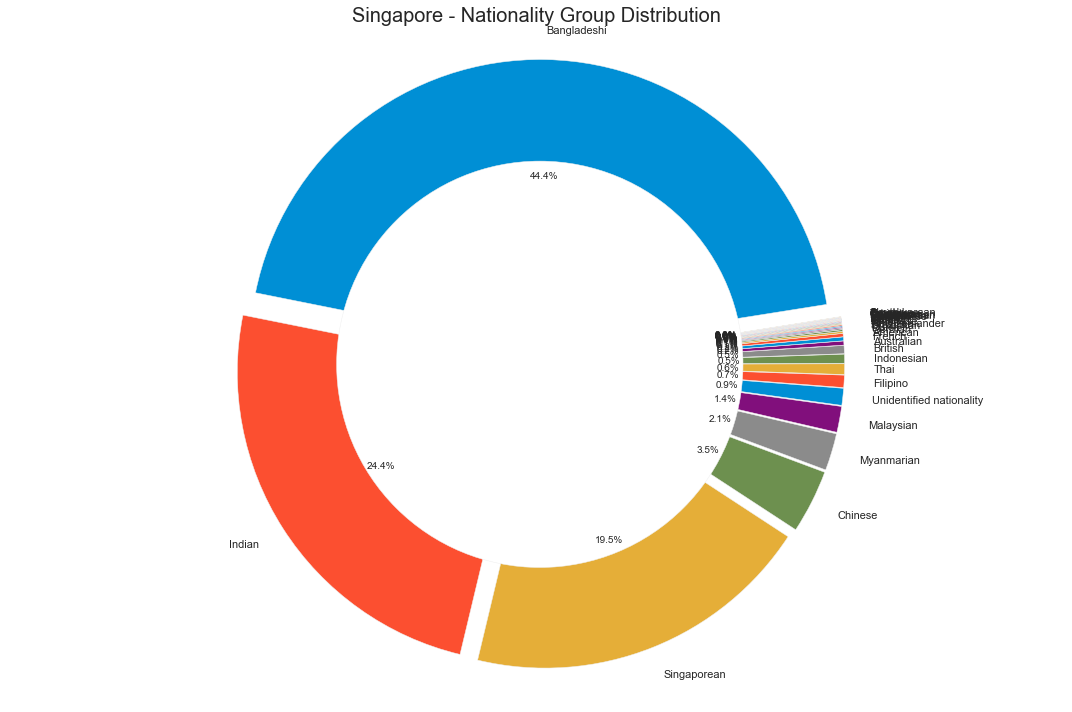

In [26]:
# # plot pie chart showing SG age group distribution for covid cases
# labels = list(nat_details_df.nationality)
# sizes = list(nat_details_df.total)

# explode = []

# for i in labels:
#     explode.append(0.05)
    
# plt.figure(figsize= (15,10))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
# centre_circle = plt.Circle((0,0),0.70,fc='white')

# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
# plt.title('Singapore - Nationality Group Distribution',fontsize = 20)
# plt.axis('equal')  
# plt.tight_layout()

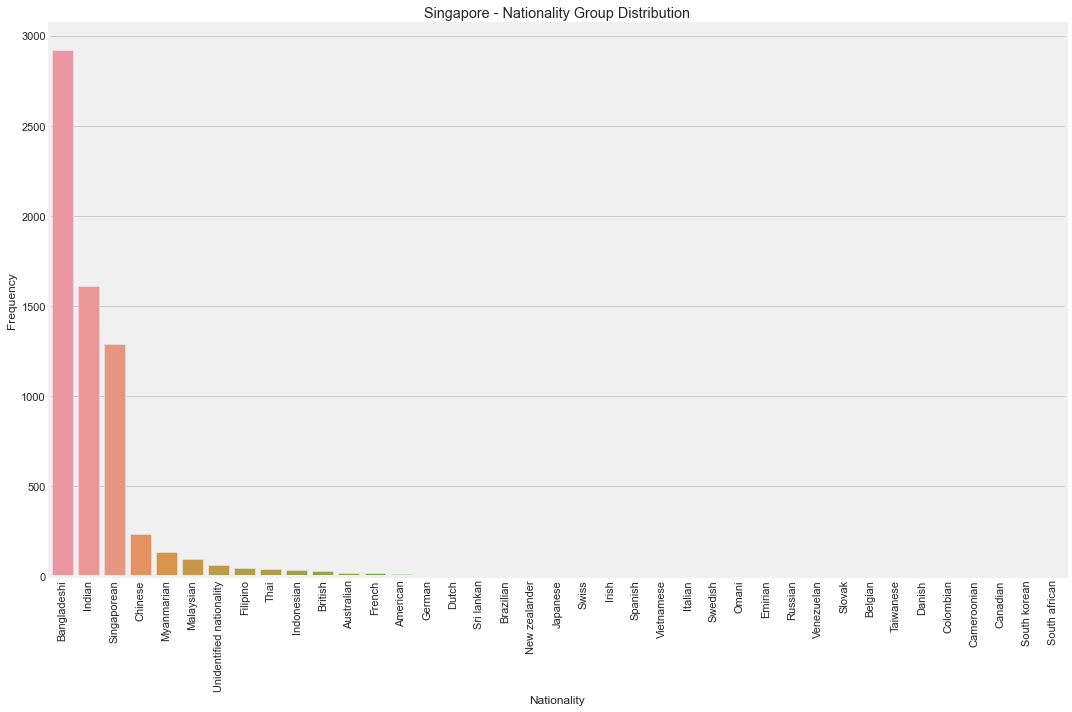

In [27]:
# bar plot to chart singapore confirmed nationality distribution for covid cases
plt.figure(figsize=(15,10))
sns.barplot(x = sg_df['nationality'].value_counts().index,
            y = sg_df['nationality'].value_counts().values)

plt.xlabel('Nationality')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Singapore - Nationality Group Distribution')
plt.tight_layout()


We observed that of the 39 different nationalities that have been confirmed in Singaore, Bangladeshis and Indians make up the majority, followed by Singaporeans. The rest of the foreigners make up a relatively small percentage of the infected.

In [28]:
rec_df

,rec_time,total
0,N.A,5784
1,1-2 weeks,297
2,2-3 weeks,235
3,>3 weeks,144
4,<1 week,128


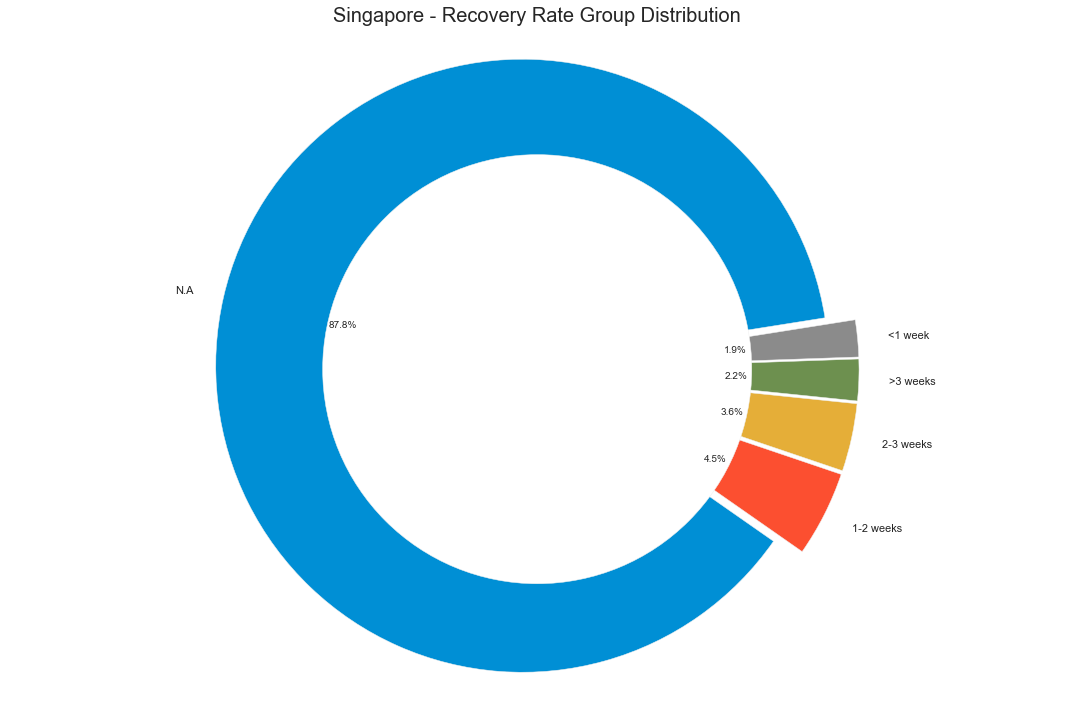

In [29]:
# plot pie chart showing SG age group distribution for covid cases
labels = list(rec_df.rec_time)
sizes = list(rec_df.total)

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Singapore - Recovery Rate Group Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

N.A. refers to confirmed cases that are either deceased or hopeful to recover, but yet so.

In [33]:
comb_ext.groupby('Country/Region').sum().mean()

confirmed    296660.788043
deaths        17870.733696
recovered     75091.771739
dtype: float64

In [31]:
comb_ext[comb_ext['deaths'] <0]

,Country/Region,confirmed,deaths,recovered
